# 最初に
下記を参考に「自作のモデル」でcamが確認できるようにしたい。  
https://qiita.com/haru1977/items/45269d790a0ad62604b3

### 流れ
1.camを表示させる関数を作成  
→必要な引数は「モデル」、「対象画像」、「対象層の名前」の３つかな。  
2.自作のモデルを学習  
3.利用してみる  

In [2]:
# cv2のインストール
! pip install opencv-python

    100% |████████████████████████████████| 25.0MB 2.1MB/s eta 0:00:01
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# coding:utf-8


################
# 1.camを表示させる関数を作成
# とりあえずは下記のコピペを実行してみる。
# https://qiita.com/haru1977/items/45269d790a0ad62604b3
################

import pandas as pd
import numpy as np
import cv2
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model

K.set_learning_phase(1) #set learning phase



def Grad_Cam(input_model, x, layer_name):
    '''
    Args:
       input_model: モデルオブジェクト
       x: 画像(array)
       layer_name: 畳み込み層の名前

    Returns:
       jetcam: 影響の大きい箇所を色付けした画像(array)

    '''

    # 前処理
    X = np.expand_dims(x, axis=0)

    X = X.astype('float32')
    preprocessed_input = X / 255.0


    # 予測クラスの算出
    predictions = model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])
    class_output = model.output[:, class_idx]


    #  勾配を取得
    conv_output = model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
    grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
    gradient_function = K.function([model.input], [conv_output, grads])  # model.inputを入力すると、conv_outputとgradsを出力する関数

    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0], grads_val[0]

    # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)


    # 画像化してヒートマップにして合成
    cam = cv2.resize(cam, (224, 224), cv2.INTER_LINEAR) # 画像サイズは224
    cam = np.maximum(cam, 0) 
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam) + x / 2)   # もとの画像に合成

    return jetcam


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size c

In [3]:
################
# 2.自作のモデルを学習
# ResNet50
################

import os
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import TensorBoard
import numpy as np
import glob

# 学習時の結果をあとで確認するための関数です。
def save_history(history, result_file):
    loss = history.history['loss']
    acc = history.history['acc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_acc']
    nb_epoch = len(acc)

    with open(result_file, "w") as fp:
        fp.write("epoch\tloss\tacc\tval_loss\tval_acc\n")
        for i in range(nb_epoch):
            fp.write("%d\t%f\t%f\t%f\t%f\n" % (i, loss[i], acc[i], val_loss[i], val_acc[i]))

# 今回分類するクラスを格納します。
classes = ['001.nabeneji', '002.tyouneji', '003.saraneji']

# ハイパーパラメータ 
batch_size = 32
nb_classes = len(classes)
img_rows, img_cols = 224, 224
channels = 3

# データの格納ディレクトリ
log_dir = '/home/ec2-user/SageMaker/class_activation_map/tensorboard'
dir_base = '/home/ec2-user/SageMaker/class_activation_map/data2'
path_train = dir_base + '/train'
path_validation = dir_base + '/validation'

# 利用するデータについて
nb_train_samples =  len(glob.glob("{0}/*/*.jpg".format(path_train), recursive=True))
nb_val_samples = len(glob.glob("{0}/*/*.jpg".format(path_validation), recursive=True))
nb_epoch = 50


# callbacks
callbacks = TensorBoard(log_dir=log_dir,
                                        histogram_freq=0)


# resnet50のパラメータをLOAD
# Fully-connected層（FC）はいらないのでinclude_top=Falseを指定
input_tensor = Input(shape=(img_rows, img_cols, channels))
resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

# FC層を新規構築
# 「バッチ数」以外をFlattenへ入力
top_model = Sequential()
top_model.add(Flatten(input_shape=resnet50.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
# top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes, activation='softmax'))

# resnet50とFCを接続
model = Model(input=resnet50.input, 
              output=top_model(resnet50.output))

'''
# 最後のconv層の直前までの層はパラメータを更新しない
for layer in model.layers[:49]: # 15→49
    layer.trainable = False
'''
for layer in model.layers:
    layer.trainable = True


# compile
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# generator
# トレーニング用では汎化性能向上のための処理を追加している(回転、ズーム、水平方向の反転)
# 一方、検証用は正規化のみでOK！
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    directory=path_train,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

validation_generator = test_datagen.flow_from_directory(
    directory=path_validation,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:71: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


Found 70 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [4]:
################
# 3.学習
################


# Fine-tuning
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=nb_train_samples / batch_size,
    nb_epoch=nb_epoch,
    validation_data=validation_generator,
    callbacks=[callbacks],  # tensorboardで処理内容を確認する
    validation_steps=None)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<keras_pre..., steps_per_epoch=2.1875, validation_data=<keras_pre..., callbacks=[<keras.ca..., validation_steps=None, epochs=50)`


Epoch 1/50
3/2 [=========================================] - 9s 3s/step - loss: 1.7729 - acc: 0.4206 - val_loss: 1.5389 - val_acc: 0.4667
Epoch 2/50
3/2 [=========================================] - 2s 679ms/step - loss: 2.2606 - acc: 0.4320 - val_loss: 0.4785 - val_acc: 0.8333
Epoch 3/50
3/2 [=========================================] - 2s 679ms/step - loss: 0.8477 - acc: 0.6824 - val_loss: 1.3575 - val_acc: 0.6333
Epoch 4/50
3/2 [=========================================] - 2s 683ms/step - loss: 0.6074 - acc: 0.7726 - val_loss: 1.1978 - val_acc: 0.6333
Epoch 5/50
3/2 [=========================================] - 2s 679ms/step - loss: 0.4163 - acc: 0.8640 - val_loss: 0.3180 - val_acc: 0.9333
Epoch 6/50
3/2 [=========================================] - 2s 680ms/step - loss: 0.0575 - acc: 0.9772 - val_loss: 0.1522 - val_acc: 0.9667
Epoch 7/50
3/2 [=========================================] - 2s 681ms/step - loss: 0.1897 - acc: 0.9434 - val_loss: 0.0250 - val_acc: 1.0000
Epoch 8/50
3/2 [

In [5]:
################
# 4.重みの出力
# https://keras.io/ja/getting-started/faq/#keras-model
################


dir_output_model = './model'
model_filename = 'model.h5'

model.save(dir_output_model + '/' + model_filename)


In [6]:
################
# modelに重みをLOADする前に、同名モデルがあったらメモリを解放すること
################
del model

In [4]:
################
# 5.ネットワーク＆重みのLOAD
################


from keras.models import load_model

dir_output_model = './model'
model_filename = 'model.h5'

model = load_model(dir_output_model + '/' + model_filename)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

[[0.718954   0.10370164 0.17734437]]


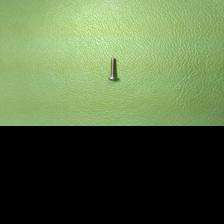

In [38]:
################
# 6.推論
################


from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import preprocess_input
import numpy as np

# 正解した画像
# dir_input = './data2/train/001.nabeneji/1534519174.0546207.jpg' 
# dir_input = './data2/train/002.tyouneji/1534519172.3240132.jpg' 

# 間違えた画像
dir_input = './data/train/001.nabeneji/1535641635.527358.jpg' 

# classes = ['001.nabeneji', '002.tyouneji', '003.saraneji']

img = load_img(dir_input, target_size=(224, 224))
x_array = img_to_array(img)
x_array = np.expand_dims(x_array, axis=0)
x_array = preprocess_input(x_array)

# 推論結果を表示
preds = model.predict(x_array)
print(preds)

# 画像を表示
x = img_to_array(load_img(dir_input, target_size=(224,224)))
array_to_img(x)

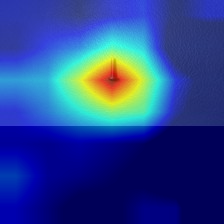

In [39]:
#指定した画像のアクティベーションマップを確認(正解した画像ver)

image = Grad_Cam(model, x, 'activation_49') 
array_to_img(image)

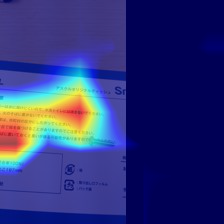

In [16]:
#指定した画像のアクティベーションマップを確認(間違えた画像ver)

image = Grad_Cam(model, x, 'activation_49') 
array_to_img(image)